In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import string
import gensim.corpora as corpora
import nltk
import plotly.express as px

from matplotlib import pyplot as plt
from pymystem3 import Mystem
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from nltk.corpus import stopwords
from MulticoreTSNE import MulticoreTSNE as TSNE
from wordcloud import WordCloud
from tqdm.auto import tqdm
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from multiprocessing import cpu_count
from IPython.core.display import HTML

In [2]:
nltk.download("stopwords")


# подправим стиль для отображения графиков по центру
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


[nltk_data] Downloading package stopwords to /home/alexey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка данных

In [3]:
# существующие каналы
raw_channel = pd.read_json('data/channels.json')
# пользователи слака
raw_user = pd.read_json('data/users.json')
# информация о должностях пользователей
raw_user_job = pd.read_json('data/users_job.json')
# сообщение из слака
raw_message = pd.read_json('data/messages.json')


In [4]:
raw_user.isna().sum()

user_id           0
deleted           0
real_name         0
display_name      0
email            19
tz_offset       176
area              0
dtype: int64

In [5]:
raw_user_job.drop(columns=['email']).head(5)

title             geo  \
0  КРД Управление фронт-офисных систем Заместител...       Краснодар   
1                                         Неизвестно            None   
2    ЯКТ Отдел сопровождения рабочих мест Специалист          Якутия   
3          ХМ Отдел технической поддержки Cпециалист  Ханты-Мансийск   
4                                         Неизвестно            None   

                  position                        department  
0       начальник аналитик      отдел бизнес-анализа продажи  
1                     None                              None  
2  специалист поддержки РМ  отдел сопровождения рабочих мест  
3     специалист поддержки      служба технической поддержки  
4                     None                              None

In [6]:
raw_user_job.isna().sum()

email          0
title          0
geo           94
position      94
department    96
dtype: int64

In [7]:
raw_message.drop(columns=['user_id']).head(5)

text            ts     area  \
0  <!here> база цссу temp обновлена. проверьте ра...  1.564069e+09  support   
1                         отличная характеристика)))  1.561446e+09  support   
2  надо учесть эти характеристики в новой оценке ...  1.561450e+09  support   
3                          а у нас будет оценка 360?  1.561454e+09  support   
4                                       не исключено  1.561454e+09  support   

    channel  
0  1c_uchet  
1  1c_uchet  
2  1c_uchet  
3  1c_uchet  
4  1c_uchet

In [8]:
raw_message.isna().sum()

text       0
user_id    0
ts         0
area       0
channel    0
dtype: int64

# Предобработка данных

## Чистка данных

In [9]:
# дополним информацию о пользователях их должностями

raw_user = raw_user.merge(raw_user_job, how='left', on='email')

In [10]:
# удалим ботов

raw_user.drop(raw_user[raw_user.email.isna()].index, inplace=True)

In [11]:
# заполним пропуски у сотрудников которые больше не работают в компании сдедовательно получить их занимаемые должности не получилось

raw_user[['geo', 'position', 'department', 'title']] = raw_user[['geo', 'position', 'department', 'title']].fillna('уволился')
raw_user['geo'] = raw_user['geo'].fillna('неизвестно')

In [12]:
# добавим почту отправителя для идентификации

raw_user = raw_user.set_index('user_id')
raw_message['email'] = raw_message.user_id.replace(raw_user.email.to_dict())

In [13]:
# дополним сообщения информацией об пользователе
# поскольку для каждого пространства в слаке создается отдельный пользователь со своим иднтификатором, сгруппируем
# по почте и отберем имя, географическое положение, должность, отдел

user_info = raw_user.groupby('email').first()[['real_name', 'geo', 'position', 'department']]
raw_message = raw_message.merge(user_info, how='left', on='email')

In [14]:
# разобьем время на год, месяц, день, и т.д.

raw_message.ts = raw_message.ts.astype(str).str.split('.').apply(lambda x: x[0])
raw_message.ts = pd.to_datetime(raw_message.ts, unit='s')
raw_message['year'] = raw_message.ts.dt.year
raw_message['month'] = raw_message.ts.dt.month
raw_message['day'] =  raw_message.ts.dt.day
raw_message['hour'] = raw_message.ts.dt.hour
raw_message['weekday'] = raw_message.ts.dt.weekday

In [15]:
# удалим призивы пользователей, эмоджи и т.п.

raw_message['text_clean'] = raw_message.text.str.replace(':[a-z_]+:', ' ')

In [16]:
# удалим переход на новую строку

raw_message.text_clean = raw_message.text_clean.str.replace('\\n', ' ')

In [17]:
# удалим ссылки

raw_message.text_clean = raw_message.text_clean.str.replace("<.+?>", ' ')

In [18]:
# удалим пунктуацию

punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
raw_message.text_clean = raw_message.text_clean.str.translate(punctuation)

In [19]:
# удалим сообщения которые после очистки состоят только из пробелов

raw_message.drop(
    raw_message[raw_message.text_clean.apply(lambda x: len(set(x) - set(' ')) == 0)].index.values,
    inplace=True
)

In [20]:
raw_message.isna().sum()

text            0
user_id         0
ts              0
area            0
channel         0
email           0
real_name     601
geo           601
position      601
department    601
year            0
month           0
day             0
hour            0
weekday         0
text_clean      0
dtype: int64

In [21]:
raw_message.dropna(inplace=True)

In [22]:
raw_message.reset_index(drop=True, inplace=True)

## Лемматизация сообщений

In [23]:
stemer = Mystem()
def lemmatize(text, stemer):
    return ''.join(stemer.lemmatize(text)).strip()

raw_message.text_clean = raw_message.text_clean.apply(lemmatize, args=(stemer,))

In [24]:
raw_message.drop(columns=['user_id', 'email', 'real_name']).head(5)

text                  ts  \
0  <!here> база цссу temp обновлена. проверьте ра... 2019-07-25 15:31:47   
1                         отличная характеристика))) 2019-06-25 07:00:39   
2  надо учесть эти характеристики в новой оценке ... 2019-06-25 08:10:00   
3                          а у нас будет оценка 360? 2019-06-25 09:05:26   
4                                       не исключено 2019-06-25 09:06:31   

      area   channel             geo              position  \
0  support  1c_uchet  Ханты-Мансийск        разработчик 1c   
1  support  1c_uchet          Тюмень        разработчик 1c   
2  support  1c_uchet  Ханты-Мансийск        разработчик 1c   
3  support  1c_uchet     Новосибирск  специалист поддержки   
4  support  1c_uchet     Новосибирск  руководитель проекта   

                              department  year  month  day  hour  weekday  \
0                    отдел разработки 1c  2019      7   25    15        3   
1                    отдел разработки 1c  2019      6   25     7        1   
2                    отдел разработки 1c  2019      6   25     8        1   
3  отдел тестирования и сопровождения 1c  2019      6   25     9        1   
4           отдел проектной деятельности  2019      6   25     9        1   

                                          text_clean  
0  база цсса temp обновлять  проверять работоспос...  
1                            отличный характеристика  
2  надо учитывать этот характеристика в новый оце...  
3                             а у мы быть оценка 360  
4                                       не исключать

# Немого визуализаций

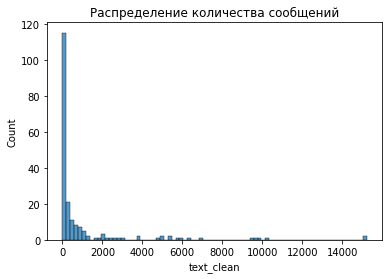

In [25]:
# количество сообщений по каналам

count_message_in_channel = raw_message.groupby('channel').text_clean.count()
ax = sns.histplot(count_message_in_channel);
ax.set_title('Распределение количества сообщений');

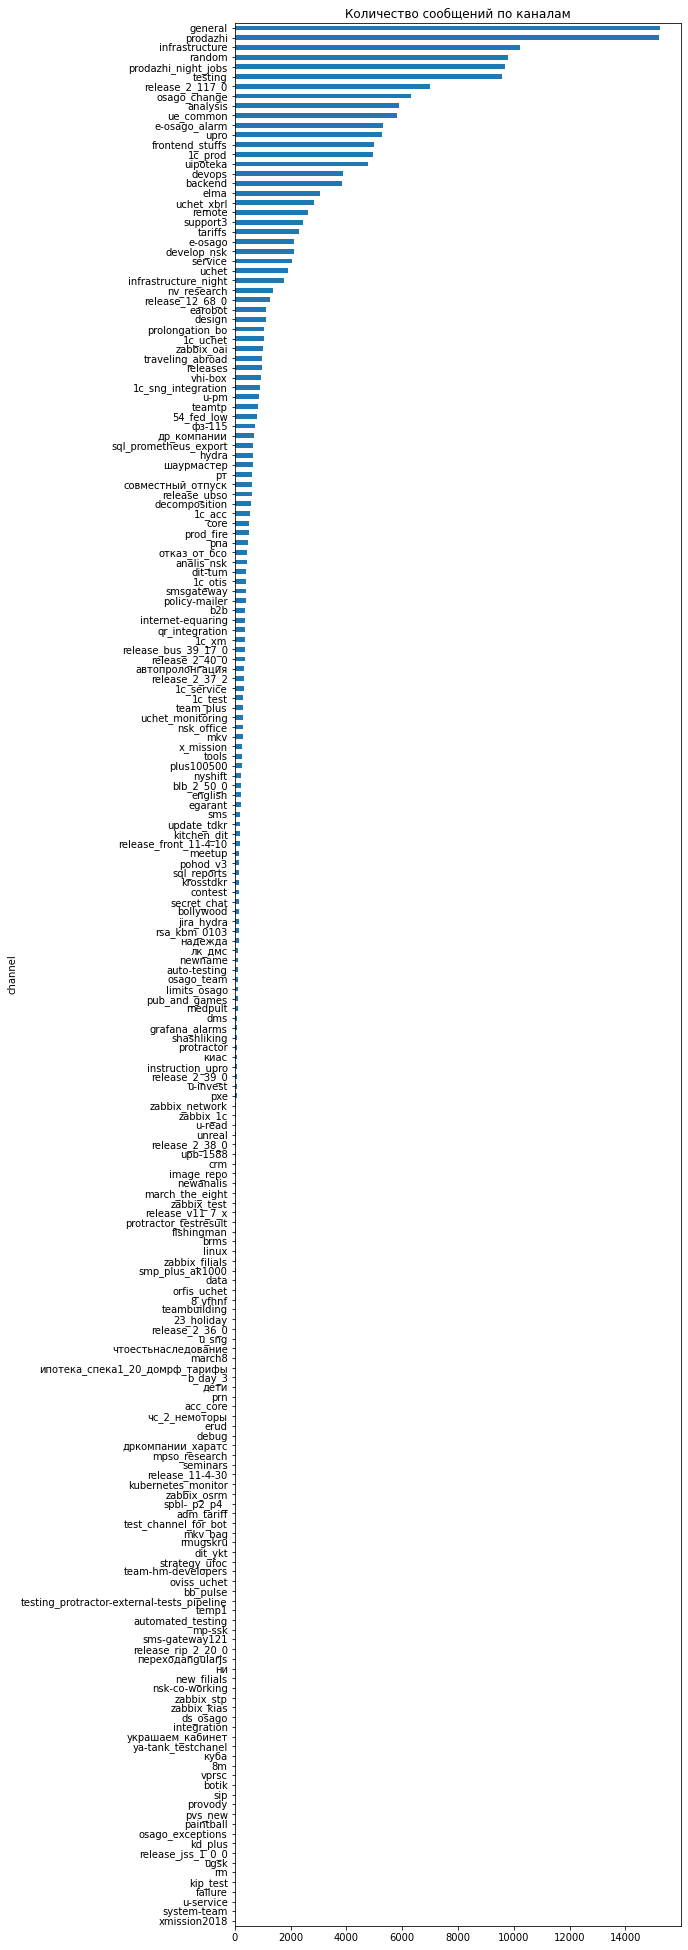

In [26]:
plt.figure(figsize=(8, 35))
ax = count_message_in_channel.sort_values().plot.barh();
ax.set_title('Количество сообщений по каналам');

In [27]:
# распределение длины сообщений

coutn_words_in_message = raw_message.text_clean.apply(lambda i: len(i.split()))

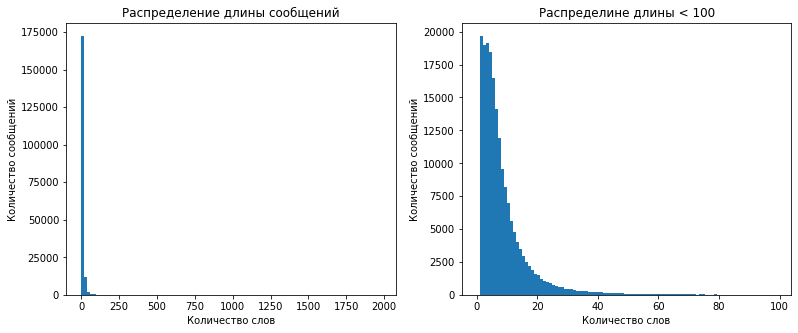

In [28]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
plt.hist(coutn_words_in_message, bins=100)
plt.title('Распределение длины сообщений')
plt.ylabel('Количество сообщений')
plt.xlabel('Количество слов')

plt.subplot(1, 2, 2)
plt.hist(coutn_words_in_message[coutn_words_in_message < 100], bins=100);
plt.title('Распределине длины < 100')
plt.ylabel('Количество сообщений')
plt.xlabel('Количество слов');

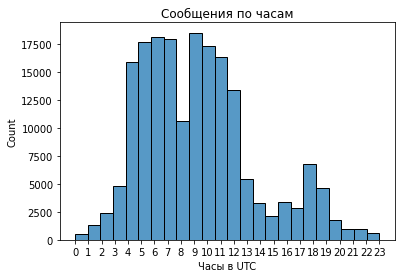

In [29]:
# количество сообщений по часам

ax = sns.histplot(raw_message.hour, bins=24)
ax.set_xticks(range(0,24))
ax.set_title('Сообщения по часам')
ax.set_xlabel('Часы в UTC');

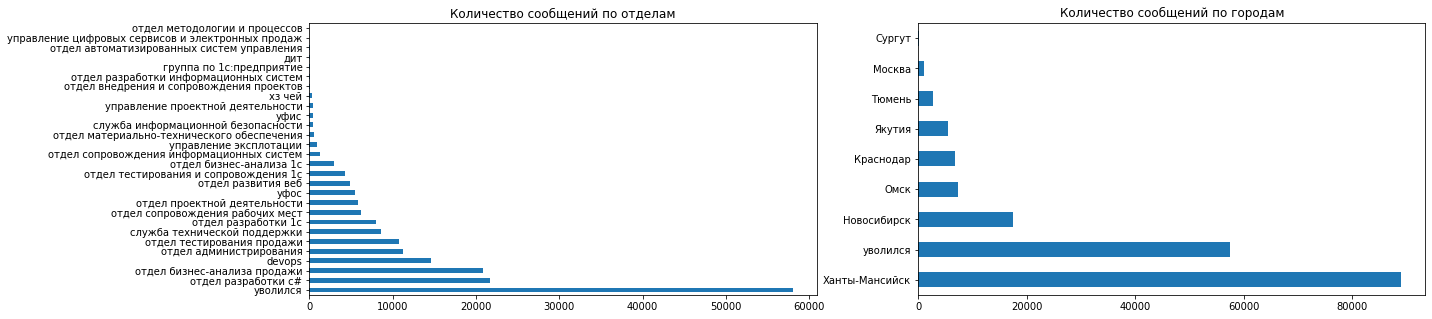

In [30]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
raw_message.department.value_counts().plot.barh()
plt.title('Количество сообщений по отделам')


plt.subplot(1, 2, 2)
raw_message.geo.value_counts().plot.barh()
plt.title('Количество сообщений по городам');

# Модель LDA

In [31]:
# Посмотрим о чем пишет служба информационной безопасности

mask = (coutn_words_in_message>3) & (raw_message.department=='служба информационной безопасности')

In [32]:
df_message = raw_message[mask]

In [33]:
# выровним индекс от 0 до ...
df_message.reset_index(inplace=True, drop=True)

In [34]:
stop_words = stopwords.words('russian')
stop_words.extend(['это', 'ага', 'ясно', 'окей', 'привет', 'спасибо', 'ока', 'пока'] + stopwords.words('english'))

In [35]:
tokens = [list(filter(lambda word: word not in stop_words, simple_preprocess(message))) for message in df_message.text_clean]

In [36]:
bigram = Phrases(tokens, min_count=2, threshold=10)

In [37]:
# score = [i[1] for i in list(bigram.export_phrases(tokens, out_delimiter=b'_'))]
# print(len(score))
# plt.hist(score, bins=100);

In [38]:
tokens = [bigram[token] for token in tokens]

In [39]:
# подготвока корпуса

d = corpora.Dictionary(tokens)
d.filter_extremes(no_below=4, no_above=0.4)

In [40]:
corpus = [d.doc2bow(message) for message in tokens]
corpus = TfidfModel(corpus)[corpus]

In [41]:
def fit_model(n_topics):
    model_gensim = LdaMulticore(
    random_state=31,
    corpus=corpus,
    id2word=d,
    workers=cpu_count(),
    num_topics=n_topics
    )
    coherence_model_lda = CoherenceModel(model=model_gensim, texts=tokens, dictionary=d, coherence='c_v')
    return [model_gensim, coherence_model_lda.get_coherence()]
    

In [42]:
coherences = []
x_line = []
for param in tqdm(range(1, 50, 3)):
    model_gensim, score = fit_model(param)
    coherences.append(score)
    x_line.append(param)
    

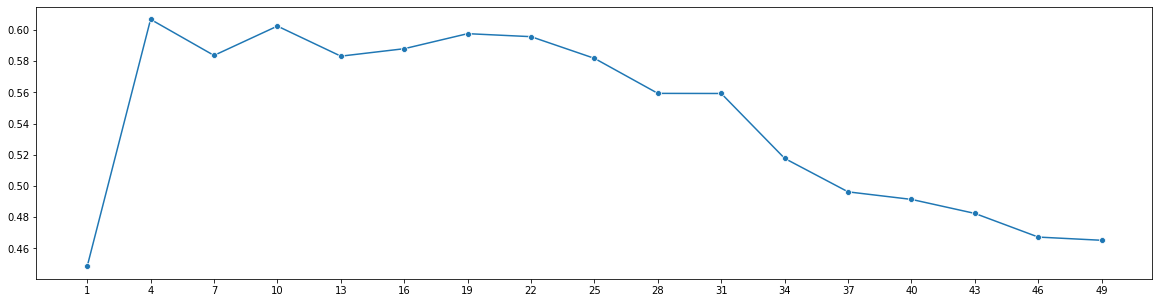

In [43]:
plt.figure(figsize=(20,5))
sns.lineplot(y=coherences, x=x_line, marker='o').set(xticks=x_line);

In [44]:
num_topics = 4
model_gensim, score = fit_model(num_topics)

In [45]:
topics = model_gensim.show_topics(num_topics=num_topics, num_words=50,formatted=False)

In [46]:
def plot_word_cloud(topic_number): 
    text = dict(topics[topic_number][1])
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=500, height=500, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(12, 7))
    plt.title(f"Топик номер {topic_number}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off');

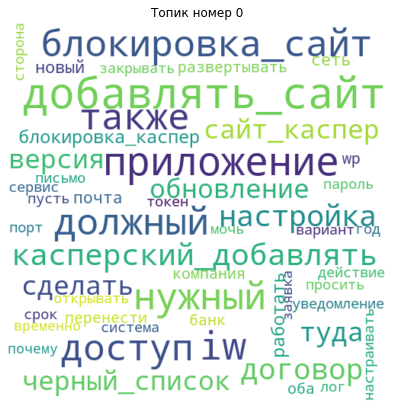

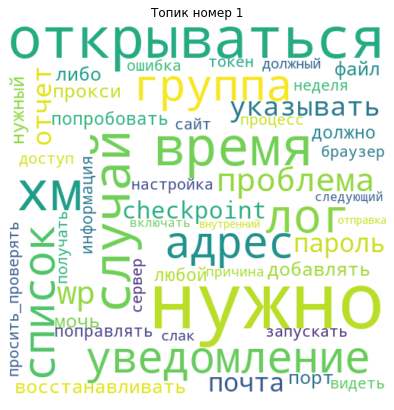

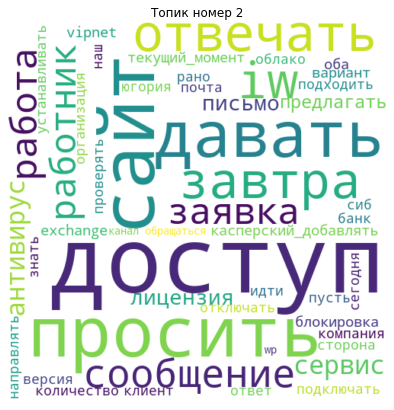

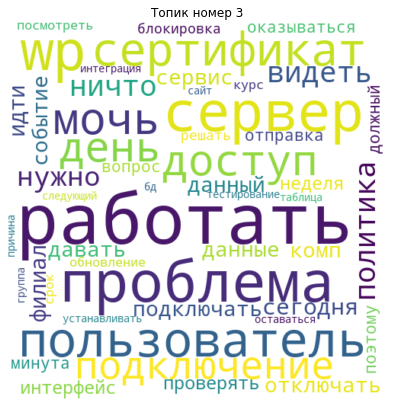

In [47]:
for i in range(0, num_topics):
    plot_word_cloud(topic_number=i)

# Модель Doc2Vec

In [48]:
# Посмотрим сложатся ли пользователи в группы

In [49]:
mask = coutn_words_in_message > 3
df_message = raw_message[mask]
df_message.reset_index(inplace=True, drop=True)

In [50]:
# подготовим данные для модели
tokens = [list(filter(lambda word: word not in stop_words, simple_preprocess(message))) for message in df_message.text_clean]
bigram = Phrases(tokens, min_count=2, threshold=10)
tokens = [bigram[token] for token in tokens]

tag_message = [TaggedDocument(message, [i]) for i, message in enumerate(tokens)]

In [51]:
# обучим модель
model_doc = Doc2Vec(vector_size=128, min_count=4, epochs=40)
model_doc.build_vocab(tag_message)
model_doc.train(tag_message, total_examples=model_doc.corpus_count, epochs=model_doc.epochs, word_count=cpu_count)

In [52]:
vec_message  = np.array([model_doc.infer_vector(message) for message in tqdm(tokens)])

In [53]:
# вычислим средний вектор для каждого пользователя
mean_vec_message = np.empty((0, vec_message.shape[1]))
desc = []
for email in tqdm(df_message.email.unique()):
    department = raw_user[raw_user.email == email].department.iloc[0]
    position = raw_user[raw_user.email == email].position.iloc[0]
    desc.append({'position': position, 'department': department})
    index = df_message[df_message.email == email].index.values
    mean_vec_message = np.vstack([mean_vec_message, np.mean(vec_message[index,:], axis=0, keepdims=True)])
desc = pd.DataFrame(desc)

## Визуализируем близость пользователей

In [54]:
tsne_doc = TSNE(perplexity=50, random_state=31).fit_transform(mean_vec_message)
df_tsne = pd.DataFrame({'x':tsne_doc[:,0], 'y':tsne_doc[:,1]})
df_tsne = pd.concat([df_tsne, desc], axis=1)
df_tsne.drop(df_tsne[df_tsne['department'] == 'уволился'].index, inplace=True)

In [58]:
# динамическая картинка. ее можно посмотреть если открыть через notebook через сервс https://nbviewer.jupyter.org/

px.scatter(df_tsne, x='x', y='y', color='department', color_discrete_sequence=px.colors.qualitative.Dark24)

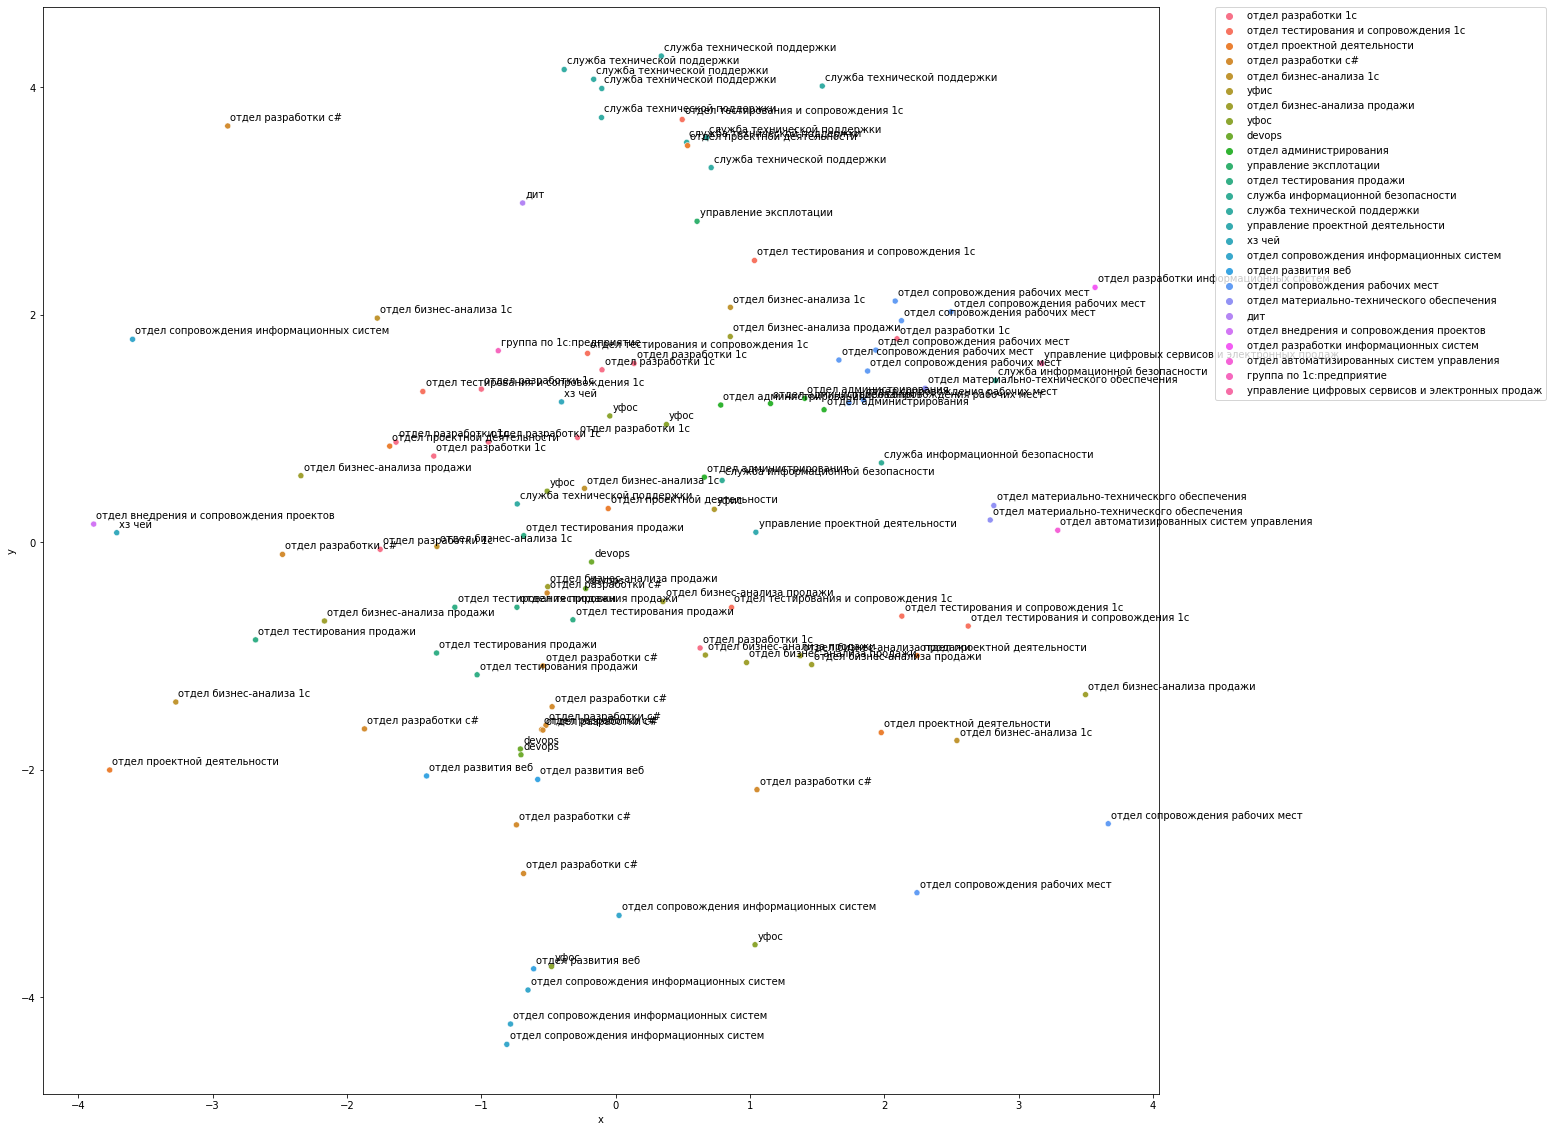

In [60]:
# статический вариант картинки ваше
plt.figure(figsize=(20,20))

ax = sns.scatterplot(data=df_tsne, x='x', y='y', hue='department');

for i, row in df_tsne.iterrows():
    ax.text(row['x']+0.02, row['y']+0.05, row['department'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

Получились некоторые отделы, сотрудники которых, группируются не далеко друг от друга. Например: отдел соправождения рабочих мест, служба технической поддержки,отдел разработки C#